# AMLB Visualizations
This notebook contains code to generate several figures from the paper "AMLB: an AutoML Benchmark" by Gijsbers et al. (2022). As input, it assumes "cleaned logs" which are available at `http://openml-test.win.tue.nl/amlb/*_cleaned.csv` and the `CleanResults` notebook shows how they are constructed from the raw results. This notebook contains code to generate:

 - [Figure 2: CD plots with Nimenyi post-hoc test after imputing missing values with the constant predictor baseline.](#CD-Plots)
 - [Figure 3: Boxplots of framework performance across tasks after scaling the performance values from random forest (-1) to best observed (0)](#Scaled-Results)
 - [Figure 8: Time spent during search.](#Training-Duration)
 - [latex code for tables 4-9 in the appendix](#Tables)
 
The `orange` dependency for CD plots can be problematic with (some?) Windows setups, but it is possible to install only a few of `orange`'s dependencies to make it work.

*The notebook's code is pretty messy/terrible. PRs to clean it up are welcome, but must be able to produce identical plots.*

In [3]:
import math
import numpy as np
import pandas as pd

In [4]:
#classification = pd.read_csv(r"classification_cleaned.csv")
classification = pd.read_csv(r"http://openml-test.win.tue.nl/amlb/classification_cleaned.csv")
classification.name = "classification"
#regression = pd.read_csv(r"regression_cleaned.csv")
regression = pd.read_csv(r"http://openml-test.win.tue.nl/amlb/regression_cleaned.csv")
regression.name = "regression"

In [5]:
metric_by_type = {
    "auc": "Binary Classification",
    "neg_logloss": "Multiclass Classification",
    "neg_rmse": "Regression",
    "all": "All Tasks",
}

budgets = {
    "1h8c_gp3": "1 hour",
    "4h8c_gp3": "4 hours",
}

baselines = ["constantpredictor", "RandomForest", "TunedRandomForest"]
ignore = ["mlr3automl"]

def get_results(metric, budget):
    r = None
    metric = dict(logloss="neg_logloss", rmse="neg_rmse").get(metric, metric)
    # A bit complicated for a simple two filters, but this preserves more information if only requesting one take type.
    for results in [classification, regression]:
        if metric in results.metric.unique():
            if budget in results.constraint.unique():
                r = results[(results["constraint"] == budget) & (results["metric"] == metric)]
            elif budget == "all": 
                r = results[(results["metric"] == metric)]
            else:
                raise ValueError(f"{budget} must be in the results or 'all'.")
    if metric == "all":
        shared_columns = ["framework", "task", "constraint", "fold", "result", "predict_duration", "training_duration", "metric", "info"]
        combined = pd.concat([classification[shared_columns], regression[shared_columns]], ignore_index=True)
        if budget in combined.constraint.unique():
            r = combined[(combined["constraint"] == budget)]
        elif budget == "all": 
            r = combined
        else:
            print(combined.constraint.unique())
            raise ValueError(f"{budget} must be in the results or 'all'.")
    if r is None:
        raise RuntimeError(f"No results found for {metric}.")
    r = r.copy()
    r["framework"] = r["framework"].str.replace("_benchmark", "(B)")
    return r

def impute_values(results, strategy, inplace=False):
    """ Impute missing values of `results` with one of `strategy`:
          - a baseline (i.e., RandomForest, TunedRandomForest or constantpredictor)
          - worst: worst that any AutoML framework found for that fold
          - max(worst, framework): the best between worst and framework
          - min(worst, framework): the worst between worst and framework
    """
    if not inplace:
        results = results.copy()
    
    # I know this is ugly :) 
    min_or_max = min if "min(" in strategy else (max if "max(" in strategy else None)
    
    if "worst" in strategy:
        worst_results = get_extreme_result_per_job(results)
        if "," in strategy:
            new_strategy = strategy.split(', ')[-1][:-1]
            if new_strategy not in results.framework.unique():
                raise ValueError(f"{strategy} is invalid, can not find '{new_strategy}' as reference framework.")
            strategy = new_strategy
    
    lookup_table = results.set_index(["framework", "task", "fold", "constraint"])
    for index, row in results.iterrows():
        if np.isnan(row["result"]):
            task, fold, constraint = row[["task", "fold", "constraint"]]
            if strategy in results.framework.unique():
                value = lookup_table.loc[(strategy, task, fold, constraint)].result
            if min_or_max or strategy == "worst":
                worst = worst_results.loc[(task, fold, constraint)].result
                if min_or_max:
                    value = min_or_max(worst, value)
                else:
                    value = worst
            results.loc[index, "result"] = value
    return results

def get_extreme_result_per_job(results, method=min, with_baseline=False):
    """ Finds the best/worst result of an AutoML framework for each (fold, task) excluding failures. """ 
    if not with_baseline:
        results = results[~results.framework.isin(baselines)]
    worst = results.groupby(["task", "fold", "constraint"]).agg({"result": method})
    return worst

# CD Plots
Figure 2 in the paper.

In [6]:
import Orange
import matplotlib.pyplot as plt

from scipy.stats import friedmanchisquare

In [7]:
def calculcate_average_rank(results, rank_kwargs=None):
    if rank_kwargs is None:
        rank_kwargs = {}
    
    agg = results.groupby(["framework", "task"], as_index=False).mean()
    agg["rank"] = agg.groupby("task").result.rank(ascending=False, **rank_kwargs)
    return agg.groupby("framework", as_index=False)["rank"].mean()

def calculcate_rank_per_task(results, rank_kwargs=None):
    if rank_kwargs is None:
        rank_kwargs = {}
    
    agg = results.groupby(["framework", "task"], as_index=False).mean()
    agg["rank"] = agg.groupby("task").result.rank(ascending=False, **rank_kwargs)
    return agg

In [8]:
def plot_cd(results, filename=None):
    ranks = calculcate_rank_per_task(results, rank_kwargs=dict(method="average", na_option="bottom"))
    r, p = friedmanchisquare(*[ranks[ranks.framework == fw]["rank"] for fw in ranks.framework.unique()])
    if p >= 0.05:
        # Given the number of results we don't really expect this to happen.
        raise RuntimeError("Ranks are not statistically significantly different.")
    rank_stats = calculcate_average_rank(results, rank_kwargs=dict(method="average", na_option="bottom"))
    n_tasks = results.task.nunique()
    critical_difference = Orange.evaluation.compute_CD(rank_stats["rank"], n_tasks)
    Orange.evaluation.graph_ranks(
        rank_stats["rank"],
        rank_stats["framework"],
        cd=critical_difference,
        width=6,
        textspace=1.5,
        filename=filename
    )

generating cd-binary-1h8c_gp3-constantpredictor.pdf
generating cd-multiclass-1h8c_gp3-constantpredictor.pdf
generating cd-regression-1h8c_gp3-constantpredictor.pdf
generating cd-binary-4h8c_gp3-constantpredictor.pdf
generating cd-multiclass-4h8c_gp3-constantpredictor.pdf
generating cd-regression-4h8c_gp3-constantpredictor.pdf


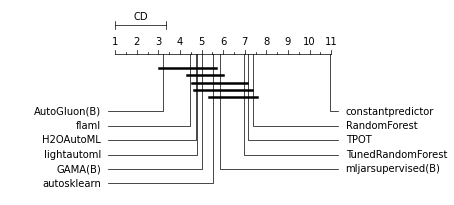

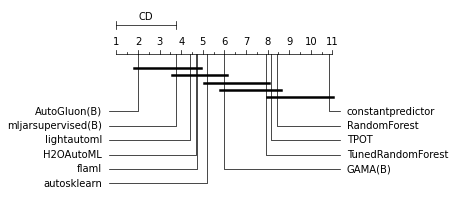

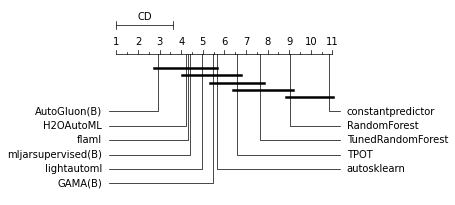

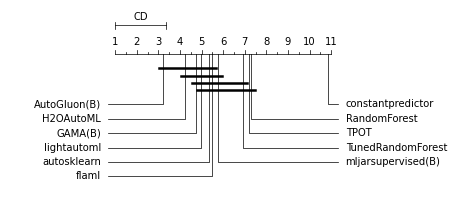

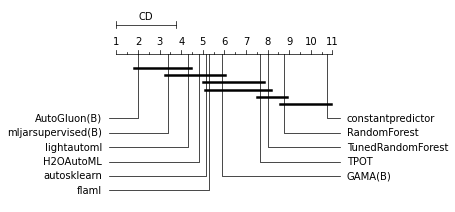

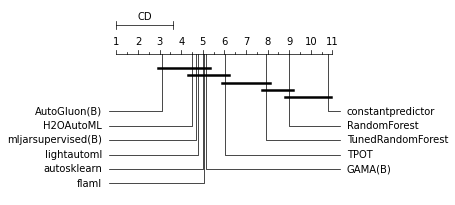

In [10]:
for constraint, time_budget in budgets.items():
    data = get_results("all", constraint)
    data["framework"] = data["framework"].str.replace("_benchmark", "(B)")
    # We exclude autosklearn2 because the metadataset overlaps with the benchmark,
    # and mlr3automl because we identified issues with the integration.
    data = data[~data["framework"].isin(["mlr3automl", "autosklearn2"])]
    data = impute_values(data, "constantpredictor")
    
    for ttype, metric in [("binary", "auc"), ("multiclass", "neg_logloss"), ("regression", "neg_rmse")]:
        results = data[data.metric.isin([metric])]
        filename = f"cd-{ttype}-{constraint}-constantpredictor.pdf"
        print("generating", filename)
        plot_cd(results, filename=filename)

# Scaled Results
Figure 3 in the paper.

In [14]:
def add_rescale(data, lower):
    lookup = data.set_index(["framework", "task", "constraint"]).sort_index()
    oracle = data.groupby(["task", "constraint"]).max().sort_index()
    
    for index, row in data.sort_values(["task"]).iterrows():
        task, constraint = row["task"], row["constraint"]
        lb = lookup.loc[(lower, task, constraint)].result
        ub = oracle.loc[(task, constraint)].result
        if lb == ub:
            data.loc[index, "rescaled"] = float("nan")
        else:
            v = -((row["result"] - lb) / (ub - lb)) + 1
            data.loc[index, "rescaled"] = v
    return data
            

generating box-rescaled-binary-classification-1h8c_gp3-constantpredictor.pdf
generating box-rescaled-multiclass-classification-1h8c_gp3-constantpredictor.pdf
generating box-rescaled-regression-1h8c_gp3-constantpredictor.pdf
generating box-rescaled-binary-classification-4h8c_gp3-constantpredictor.pdf
generating box-rescaled-multiclass-classification-4h8c_gp3-constantpredictor.pdf
generating box-rescaled-regression-4h8c_gp3-constantpredictor.pdf


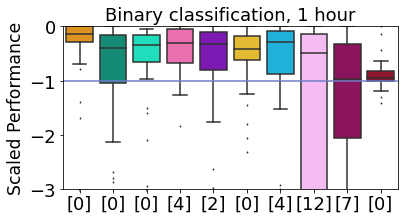

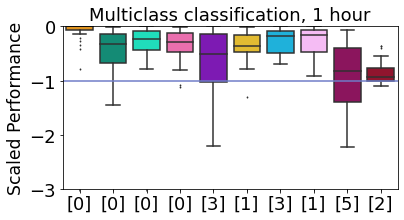

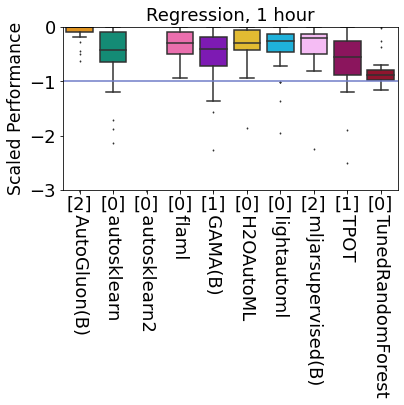

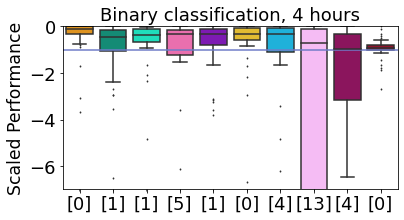

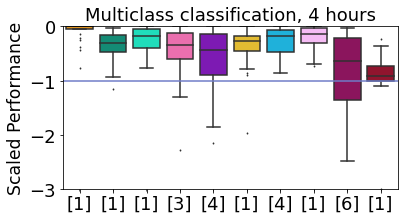

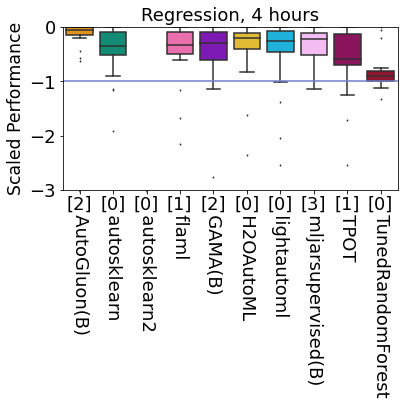

In [15]:
from matplotlib.backends.backend_pdf import PdfPages

for constraint, time_budget in budgets.items():
    data = get_results("all", constraint)
    data["framework"] = data["framework"].str.replace("_benchmark", "(B)")
    #data["framework"] = data["framework"].str.replace("autosklearn2", "[autosklearn2]")
    data = data[~data["framework"].isin(["mlr3automl"])] # , "autosklearn2"])]
    data = impute_values(data, "constantpredictor")
    
    for ttype, metric in [("binary classification", "auc"), ("multiclass classification", "neg_logloss"), ("regression", "neg_rmse")]:
        results = data[data.metric.isin([metric])]
        filename = f"box-rescaled-{ttype}-{constraint}-constantpredictor.pdf".replace(" ", "-")
        print("generating", filename)
        
        results = results.groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
        results = add_rescale(results, lower="RandomForest")
        results = results[~results.framework.isin(["RandomForest", "mlr3automl", "constantpredictor"])]
        results["rescaled"] = -results["rescaled"]

        fig, ax = box_plot(
            results,
            metric="rescaled", 
            title=f"{ttype.capitalize()}, {time_budget}", 
            hlines={-1: "#6f7cc8"}, ylog=False, 
            ylim=[-3 if metric != "auc" or constraint !="4h8c_gp3" else -7, 0],
            figsize=(6, 3),
            with_framework_names=ttype == "regression",
            add_counts="outliers"
        )
        ax.set_ylabel("Scaled Performance")
        

        with PdfPages(filename) as f:
            f.savefig(fig, bbox_inches="tight")

# Training Duration
Figure 8 in the paper.

generating train-duration-1h8c_gp3.pdf
generating train-duration-4h8c_gp3.pdf


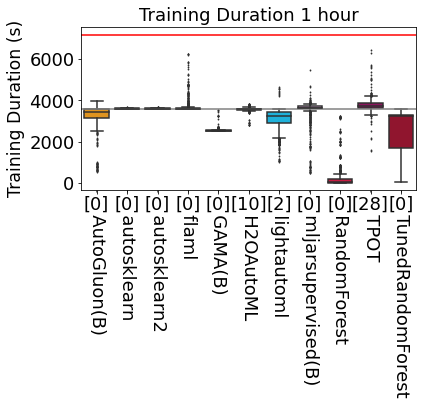

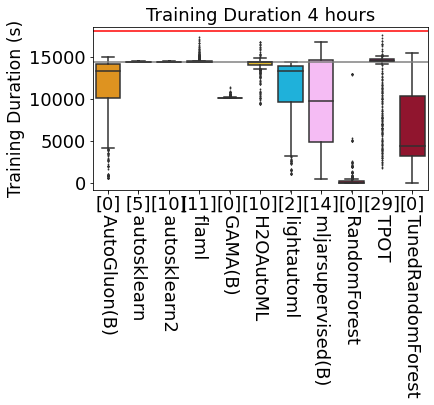

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

for constraint, time_budget in budgets.items():
    data = get_results("all", constraint)
    data["framework"] = data["framework"].str.replace("_benchmark", "(B)")
    #data["framework"] = data["framework"].str.replace("autosklearn2", "[autosklearn2]")
    data = data[~data["framework"].isin(["mlr3automl", "constantpredictor"])] # , "autosklearn2"])]
    data["timeout"] = data["info"].apply(lambda msg: isinstance(msg, str) and "Interrupting thread MainThread" in msg)
    timeout_counts = dict(data.groupby("framework").sum()["timeout"])
    #data = data[~data.result.isna()]
    # data = impute_values(data, "constantpredictor")
    #data = data.groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
    
    #results = data[data.metric.isin([metric])]
    filename = f"train-duration-{constraint}.pdf".replace(" ", "-")
    print("generating", filename)

    time_limit = 3600 if constraint == "1h8c_gp3" else 3600*4
    fig, ax = box_plot(
        data,
        metric="training_duration", 
        title=f"Training Duration {time_budget}", 
        hlines={time_limit: "grey", (time_limit+3600): "red"},
        ylog=False, 
        #ylim=[-3 if metric != "auc" or constraint !="4h8c_gp3" else -7, 0],
        figsize=(6, 3),
        exclude=[],
        add_counts=timeout_counts,
        with_framework_names=True, # ttype == "regression",
    )
    ax.set_ylabel("Training Duration (s)")


    with PdfPages(filename) as f:
        f.savefig(fig, bbox_inches="tight")

# Tables
Generating tables 4-9 of the appendix.

In [16]:
metric = "logloss"
constraint = "1h8c_gp3"
map_for_caption = {"auc": "binary classification (in AUC)", "1h8c_gp3": "one hour", "4h8c_gp3": "four hour", "logloss": "multiclass classification (log loss)"}

In [17]:
data = get_results(metric, constraint)
data = data[~data.framework.isin(["constantpredictor", "mlr3automl", "RandomForest", "TunedRandomForest"])]
data.framework.unique()

array(['AutoGluon(B)', 'H2OAutoML', 'lightautoml', 'autosklearn',
       'mljarsupervised(B)', 'flaml', 'TPOT', 'autosklearn2', 'GAMA(B)'],
      dtype=object)

In [18]:
summary = data.groupby(["framework", "task", "id"], as_index=False).agg({"result": ["mean", "std", "count"]})
summary["fails"] = 10 - summary[("result", "count")]

In [19]:
def combine_as_separate(tuple_):
    mean, std, fails = tuple_
    if fails == 10:
        return "[10]"
    else:
        return f"{mean:.2f}" + (f"[{int(fails)}]" if fails > 0 else "")
    
def combine_as_supertext(tuple_):
    mean, std, fails = tuple_
    if fails == 10:
        return "-$\hspace{0.4em}$"
    else:# if fails > 0:
        backslash = "\hspace{0.4em}"
        return f"{mean:.3f}({std:.3f})$^{{{int(fails) if int(fails) != 0 else backslash}}}$"

In [20]:
summary["display"] = summary[[("result", "mean"), ("result", "std"), ("fails", "")]].agg(combine_as_supertext, axis=1)
summary = summary[[("framework", ""), ("task", ""), ("id", ""), ("display", "")]]

In [21]:
summary.columns = ["framework", "task", "id", "display"]
summary["id"] = summary["id"].apply(lambda s: s.split("/")[-1])
summary["task"] = summary["task"].apply(lambda s: s if len(s) < 10 else (s[:8] + "..."))
summary.sort_values("framework", inplace=True, key=lambda s: s.str.lower().sort_values())

In [22]:
tab = summary.pivot(index=["id", "task"], columns="framework", values="display")
tab = tab[[c for c in sorted(tab.columns, key=lambda s: s.lower())]]

In [23]:
tab.head()

,framework,AutoGluon(B),autosklearn,autosklearn2,flaml,GAMA(B),H2OAutoML,lightautoml,mljarsupervised(B),TPOT
id,task,,,,,,,,,
10090,amazon-c...,-0.722(0.094)$^{\hspace{0.4em}}$,-0.852(0.164)$^{\hspace{0.4em}}$,-0.842(0.143)$^{\hspace{0.4em}}$,-1.122(0.179)$^{\hspace{0.4em}}$,-0.900(0.080)$^{\hspace{0.4em}}$,-1.196(0.209)$^{\hspace{0.4em}}$,-0.844(0.097)$^{\hspace{0.4em}}$,-1.211(0.163)$^{\hspace{0.4em}}$,-1.169(0.294)$^{3}$
168784,steel-pl...,-0.465(0.041)$^{\hspace{0.4em}}$,-0.530(0.029)$^{\hspace{0.4em}}$,-0.472(0.031)$^{\hspace{0.4em}}$,-0.509(0.047)$^{\hspace{0.4em}}$,-0.486(0.033)$^{\hspace{0.4em}}$,-0.484(0.039)$^{\hspace{0.4em}}$,-0.488(0.027)$^{\hspace{0.4em}}$,-0.464(0.027)$^{\hspace{0.4em}}$,-0.511(0.041)$^{\hspace{0.4em}}$
168909,dilbert,-0.012(0.004)$^{\hspace{0.4em}}$,-0.033(0.012)$^{\hspace{0.4em}}$,-0.052(0.020)$^{\hspace{0.4em}}$,-0.024(0.010)$^{\hspace{0.4em}}$,-0.169(0.031)$^{\hspace{0.4em}}$,-0.044(0.007)$^{\hspace{0.4em}}$,-0.033(0.006)$^{\hspace{0.4em}}$,-0.028(0.010)$^{\hspace{0.4em}}$,-0.166(0.103)$^{\hspace{0.4em}}$
168910,fabert,-0.686(0.027)$^{\hspace{0.4em}}$,-0.744(0.029)$^{\hspace{0.4em}}$,-0.745(0.024)$^{\hspace{0.4em}}$,-0.766(0.025)$^{\hspace{0.4em}}$,-0.753(0.020)$^{\hspace{0.4em}}$,-0.729(0.031)$^{\hspace{0.4em}}$,-0.771(0.031)$^{\hspace{0.4em}}$,-0.758(0.032)$^{\hspace{0.4em}}$,-0.857(0.041)$^{\hspace{0.4em}}$
189355,dionis,-0.273(0.004)$^{\hspace{0.4em}}$,-1.138(0.273)$^{\hspace{0.4em}}$,-0.594(0.071)$^{\hspace{0.4em}}$,-0.374(0.004)$^{1}$,-1.591(0.348)$^{\hspace{0.4em}}$,-3.351(0.120)$^{\hspace{0.4em}}$,-$\hspace{0.4em}$,-1.198(0.421)$^{8}$,-17.230(nan)$^{9}$


In [159]:
tex = tab.style.to_latex().replace("_", r"\_")

# the headers will be too wide to fit a page, we rotate them:
old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
new_header = [
    r"\footnotesize",
    r"\begin{table}",
    r"\begin{tabular}{rl" + "r" * len(tab.columns) + "}",
    r"\toprule",
    " & framework" + "".join([f"& \\rotatebox[origin=c]{{-90}}{{{framework}}}" for framework in tab.columns]) + r"\\",
    " task id & task name " + "& " * len(tab.columns) + r"\\",
    r"\midrule",
]
*body, footer = body
caption = f"\\caption{{Results for {map_for_caption[metric]} on a {map_for_caption[constraint]} budget.}}"
label = f"\\label{{tab:{metric}-{constraint}}}"
footer = [r"\bottomrule", footer, caption, label, r"\end{table}"]

with open("mytable.tex", "w") as fh:
    fh.write("\n".join(new_header + body + footer))

In [160]:
map_for_caption = {
    "auc": "binary classification (in AUC)", "neg_logloss": "multiclass classification (in logloss)", "neg_rmse": "regression (in RMSE)",
    "1h8c_gp3": "one hour", "4h8c_gp3": "four hour"
}

def generate_table_for(metric, constraint, filename="mytable.tex", exclude=["constantpredictor", "mlr3automl"]): # "RandomForest", "TunedRandomForest"
    data = get_results(metric, constraint)
    data = data[~data.framework.isin(exclude)]
    if metric != "auc":
        data["result"] = -data["result"]
    
    summary = data.groupby(["framework", "task", "id"], as_index=False).agg({"result": ["mean", "std", "count"]})
    summary["fails"] = 10 - summary[("result", "count")]
    
    def combine_as_supertext(tuple_):
        mean, std, fails = tuple_
        if fails == 10:
            return "-"
        elif fails > 0:
            return f"${mean:.2f}^{{{int(fails)}}}$"
        else:
            return f"{mean:.2f}"

    summary["display"] = summary[[("result", "mean"), ("result", "std"), ("fails", "")]].agg(combine_as_supertext, axis=1)
    summary = summary[[("framework", ""), ("task", ""), ("id", ""), ("display", "")]]
    summary.columns = ["framework", "task", "id", "display"]
    summary["id"] = summary["id"].apply(lambda s: s.split("/")[-1])
    summary["task"] = summary["task"].apply(lambda s: s if len(s) < 10 else (s[:8] + "..."))
    summary.sort_values("framework", inplace=True, key=lambda s: s.str.lower().sort_values())
    
    tab = summary.pivot(index=["id", "task"], columns="framework", values="display")
    tab = tab[[c for c in sorted(tab.columns, key=lambda s: s.lower())]]
    
    tex = tab.style.to_latex().replace("_", r"\_")

    # the headers will be too wide to fit a page, we rotate them:
    old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
    new_header = [
        r"\footnotesize",
        r"\begin{table}",
        r"\begin{tabular}{rl" + "r" * len(tab.columns) + "}",
        r"\toprule",
        " & framework" + "".join([f"& \\rotatebox[origin=c]{{-90}}{{{framework}}}" for framework in tab.columns]) + r"\\",
        " task id & task name " + "& " * len(tab.columns) + r"\\",
        r"\midrule",
    ]
    *body, footer = body
    caption = f"\\caption{{Results for {map_for_caption[metric]} on a {map_for_caption[constraint]} budget.}}"
    label = f"\\label{{tab:{metric}-{constraint}}}"
    footer = [r"\bottomrule", footer, caption, label, r"\end{table}"]

    with open(filename, "w") as fh:
        fh.write("\n".join(new_header + body + footer))

# requires \usepackage{makecell}
for metric in ["auc", "neg_logloss", "neg_rmse"]:
    for constraint in ["1h8c_gp3", "4h8c_gp3"]:
        generate_table_for(metric, constraint, f"{metric}-{constraint}-table.tex")
    

In [24]:
map_for_caption = {
    "auc": "binary classification (in AUC)", "neg_logloss": "multiclass classification (in logloss)", "neg_rmse": "regression (in RMSE)",
    "1h8c_gp3": "one hour", "4h8c_gp3": "four hour"
}

def generate_sideways_table_for(metric, constraint, filename="mytable.tex", exclude=["constantpredictor", "mlr3automl", "RandomForest", "TunedRandomForest"]): # "RandomForest", "TunedRandomForest"
    data = get_results(metric, constraint)
    data = data[~data.framework.isin(exclude)]
    if metric != "auc":
        data["result"] = -data["result"]
    
    summary = data.groupby(["framework", "task", "id"], as_index=False).agg({"result": ["mean", "std", "count"]})
    summary["fails"] = 10 - summary[("result", "count")]
    
    def combine_as_supertext(tuple_):
        fw, mean, std, fails = tuple_
        std_text = f"({std:.3f})" if metric != "neg_rmse" else f"({std:.2g})"
        if fails == 10:
            return "-$\hspace{0.4em}$"
        else:# if fails > 0:
            backslash = "\hspace{0.4em}"
            if metric != "neg_rmse":
                return f"{mean:.3f}{std_text}$^{{{int(fails) if int(fails) != 0 else backslash}}}$"
            else:
                return f"{mean:.2g}{std_text}$^{{{int(fails) if int(fails) != 0 else backslash}}}$"
    summary["display"] = summary[[("framework", ""), ("result", "mean"), ("result", "std"), ("fails", "")]].agg(combine_as_supertext, axis=1)
    summary = summary[[("framework", ""), ("task", ""), ("id", ""), ("display", "")]]
    summary.columns = ["framework", "task", "id", "display"]
    summary["id"] = summary["id"].apply(lambda s: s.split("/")[-1])
    summary["task"] = summary["task"].apply(lambda s: s.lower() if len(s) < 10 else (s.lower()[:8] + "..."))
    summary.sort_values("framework", inplace=True, key=lambda s: s.str.lower().sort_values())
    
    tab = summary.pivot(index=["id", "task"], columns="framework", values="display")
    tab = tab[[c for c in sorted(tab.columns, key=lambda s: s.lower())]]
    
    tex = tab.style.to_latex().replace("_", r"\_")

    # the headers will be too wide to fit a page, we rotate them:
    old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
    new_header = [
        r"\footnotesize",
        r"\begin{landscape}",
        r"\begin{table}",
        r"\tiny",
        r"\begin{tabular}{rl" + "r" * len(tab.columns) + "}",
        r"\toprule",
        " & framework" + "".join([f"& {framework}\ \ " for framework in tab.columns]) + r"\\",
        " task id & task name " + "& " * len(tab.columns) + r"\\",
        r"\midrule",
    ]
    *body, footer = body
    caption = f"\\caption{{Results for {map_for_caption[metric]} on a {map_for_caption[constraint]} budget, denoted as \\texttt{{mean}}(\\texttt{{std}})$^{{\\mbox{{\\texttt{{fails}}}}}}$.}}"
    label = f"\\label{{tab:{metric}-{constraint}}}"
    footer = [r"\bottomrule", footer, caption, label, r"\end{table}", r"\end{landscape}",]

    with open(filename, "w") as fh:
        fh.write("\n".join(new_header + body + footer))

# requires \usepackage{makecell}
for metric in ["auc", "neg_logloss", "neg_rmse"]:
    for constraint in ["1h8c_gp3", "4h8c_gp3"]:
        generate_sideways_table_for(metric, constraint, f"{metric}-{constraint}-table.tex")
    

Unused code for win/loss tables, champions:

In [97]:
data = get_results("all", budget="1h8c_gp3")
data = impute_values(data, strategy="constantpredictor")
data = data[~data.framework.isin(["mlr3automl", "constantpredictor"])]
data = data.groupby(["framework", "task", "constraint"], as_index=False).mean()

In [98]:
result = data[["framework", "task", "result"]]
cross = result.join(result, how="cross", rsuffix="_other")
cross = cross[(cross["framework"] != cross["framework_other"]) & (cross["task"] == cross["task_other"])]
cross.head()

,framework,task,result,framework_other,task_other,result_other
104,AutoGluon(B),APSFailure,0.992441,GAMA(B),APSFailure,0.990140
208,AutoGluon(B),APSFailure,0.992441,H2OAutoML,APSFailure,0.991928
312,AutoGluon(B),APSFailure,0.992441,RandomForest,APSFailure,0.991563
416,AutoGluon(B),APSFailure,0.992441,TPOT,APSFailure,0.990333
520,AutoGluon(B),APSFailure,0.992441,TunedRandomForest,APSFailure,0.991732


In [99]:
def win_and_loss(data):
    best_score = data[["result", "result_other"]].max(axis=1)
    return pd.Series(dict(
        win= sum(data["result"] - data["result_other"] > best_score * 0.001),
        loss= sum(data["result_other"] - data["result"] > best_score * 0.001),
        tie= sum(abs(data["result"] - data["result_other"]) < best_score * 0.001)
    ))
# cross.groupby(["framework", "framework_other"], as_index=False).apply(lambda df: sum(df["result"] > df["result_other"]))

In [100]:
wins_and_losses = cross.groupby(["framework", "framework_other"], as_index=False).apply(win_and_loss)
wins_and_losses.sample(5)

,framework,framework_other,win,loss,tie
26,H2OAutoML,autosklearn2,28,29,16
104,mljarsupervised(B),TPOT,77,28,2
94,lightautoml,TPOT,75,28,4
8,AutoGluon(B),lightautoml,72,23,9
97,lightautoml,autosklearn2,29,35,7


In [101]:
wins_and_losses["wl_str"] = wins_and_losses.apply(lambda r: f"{r['win']}/{r['loss']}/{r['tie']}", axis=1)

In [102]:
win_loss_table = wins_and_losses.pivot(index="framework", columns="framework_other", values="wl_str")
framework_order = sorted(win_loss_table.columns, key=lambda s: s.lower())
win_loss_table[framework_order].loc[framework_order]

framework_other,AutoGluon(B),autosklearn,autosklearn2,flaml,GAMA(B),H2OAutoML,lightautoml,mljarsupervised(B),RandomForest,TPOT,TunedRandomForest
framework,,,,,,,,,,,
AutoGluon(B),NaN,78/21/7,49/11/11,72/26/9,75/19/10,73/21/12,72/23/9,69/29/6,93/7/4,87/11/6,91/8/5
autosklearn,21/78/7,NaN,20/41/12,37/63/7,57/41/7,33/60/13,38/64/7,42/58/4,78/20/7,73/29/4,73/25/6
autosklearn2,11/49/11,41/20/12,NaN,33/32/9,45/19/7,29/28/16,35/29/7,31/36/4,60/7/4,59/7/5,58/8/5
flaml,26/72/9,63/37/7,32/33/9,NaN,54/42/8,51/48/11,47/55/4,53/48/4,90/12/3,76/24/5,86/16/3
GAMA(B),19/75/10,41/57/7,19/45/7,42/54/8,NaN,35/64/6,45/56/5,45/56/6,74/25/5,79/22/6,73/26/6
H2OAutoML,21/73/12,60/33/13,28/29/16,48/51/11,64/35/6,NaN,51/51/7,44/55/6,88/11/5,84/20/3,87/15/3
lightautoml,23/72/9,64/38/7,29/35/7,55/47/4,56/45/5,51/51/7,NaN,47/52/7,81/17/8,75/28/4,78/21/5
mljarsupervised(B),29/69/6,58/42/4,36/31/4,48/53/4,56/45/6,55/44/6,52/47/7,NaN,79/23/2,77/28/2,75/26/3
RandomForest,7/93/4,20/78/7,7/60/4,12/90/3,25/74/5,11/88/5,17/81/8,23/79/2,NaN,36/64/5,24/67/22


In [103]:
table = win_loss_table[framework_order].loc[framework_order]
tex = table.style.to_latex().replace("_", r"\_").replace("nan", "-")

with open("win_loss_table.tex", "w") as fh:
    fh.write(tex)
    #fh.write("\n".join(new_header + body + footer))

In [109]:
table = win_loss_table[framework_order].loc[framework_order]
tex = table.style.to_latex().replace("_", r"\_").replace("nan", "-")

# # the headers will be too wide to fit a page, we rotate them:
old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
new_header = [
    r"\footnotesize",
    r"\begin{landscape}",
    r"\begin{table}",
    r"\tiny",
    r"\begin{tabular}{r" + "r" * len(table.columns) + "}",
    r"\toprule",
    " framework A" + "".join([f"& \\rotatebox[origin=c]{{-90}}{{{framework}}}" for framework in table.columns]) + r"\\",
    #" & \ \ framework B" + "".join([f"& {framework}\ \ " for framework in table.columns]) + r"\\",
    " framework B " + "& " * len(table.columns) + r"\\",
    r"\midrule",
]
*body, footer = body
caption = f"\\caption{{Results of direct comparison between frameworks on a one hour budget across all suites. Each cell denotes the wins, losses, and ties of the row-framework over the column-framework (e.g., AutoGluon(B) wins from autosklearn 78 times). A tie is recorded if the relative difference is smaller than 0.1 percent of the greater score. No statistical tests are used.}}"
label = f"\\label{{tab:head-to-head}}"
footer = [r"\bottomrule", footer, caption, label, r"\end{table}", r"\end{landscape}",]

with open("win_loss_table.tex", "w") as fh:
    fh.write("\n".join(new_header + body + footer))

In [6]:
data = get_results("all", budget="1h8c_gp3")
data = impute_values(data, strategy="constantpredictor")
data = data[~data.framework.isin(["mlr3automl", "constantpredictor"])]
data = data.groupby(["framework", "task", "constraint"], as_index=False).mean()

,framework,task,constraint,fold,result,predict_duration,training_duration
0,AutoGluon(B),APSFailure,1h8c_gp3,4.5,0.992441,19.68,3200.36
1,AutoGluon(B),Airlines_DepDelay_10M,1h8c_gp3,4.5,-28.644900,353.30,3679.14
2,AutoGluon(B),Allstate_Claims_Severity,1h8c_gp3,4.5,-1870.653000,41.38,3642.42
3,AutoGluon(B),Amazon_employee_access,1h8c_gp3,4.5,0.898714,14.59,2513.90
4,AutoGluon(B),Australian,1h8c_gp3,4.5,0.941235,6.01,814.18


In [26]:
# Find max per task to have a reference point for `champions'
max_per_task = data.groupby(["task"]).max()["result"]
data["max_for_task"] = data["task"].apply(lambda t: max_per_task.loc[t])
data["is_champion"] = abs(data["max_for_task"] - data["result"]) < abs(data["max_for_task"] * 0.001)

In [30]:
data.groupby("framework").sum()["is_champion"]

framework
AutoGluon(B)          55
GAMA(B)               11
H2OAutoML             14
RandomForest           6
TPOT                   5
TunedRandomForest      7
autosklearn           11
autosklearn2          10
flaml                 14
lightautoml           16
mljarsupervised(B)    16
Name: is_champion, dtype: int64